In [1]:
import numpy as np
import gym

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

import matplotlib.pyplot as plt 

from nle import nethack
import gym
import minihack
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from nle import nethack
import time

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
class PolicyGradientNetwork(keras.Model):
    
    # Initialize network and archtitecture
    def __init__(self, n_actions, fc1_dims=256, fc2_dims=128, fc3_dims = 256, fc4_dims=128, fc5_dims=64):
        super(PolicyGradientNetwork,self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims 
        self.fc3_dims = fc3_dims
        self.fc4_dims = fc4_dims 
        self.fc5_dims = fc5_dims 
        self.n_actions = n_actions
        
        
        # Conv for full glyphs 
        self.conv1 = Conv2D(filters=32, kernel_size=(2,2) , padding = 'same', activation='relu')
        self.maxpool1 = MaxPool2D(pool_size=(2, 2))
        self.conv2 = Conv2D(filters=16, kernel_size=(2,2) , padding = 'same', activation='relu')
        self.maxpool2 =MaxPool2D(pool_size=(2, 2))
        self.flatten = Flatten()
        
        
        # Conv for cropped glyphs 
        self.conv3= Conv2D(filters=32, kernel_size=(2,2) , padding = 'same', activation='relu')
        self.maxpool3 = MaxPool2D(pool_size=(2, 2))
        self.conv4 = Conv2D(filters=16, kernel_size=(2,2) , padding = 'same', activation='relu')
        self.maxpool4 =MaxPool2D(pool_size=(2, 2))
        self.flatten_crop= Flatten()
        

        self.fc1 = Dense(self.fc1_dims, activation = 'relu')
        self.fc2 = Dense(self.fc2_dims, activation = 'relu')
        self.fc3 = Dense(self.fc3_dims, activation = 'relu')
        self.fc4 = Dense(self.fc4_dims, activation = 'relu')
        self.fc5 = Dense(self.fc5_dims, activation = 'relu')
        
        
        self.pi = Dense(self.n_actions, activation = 'softmax')
    
    # Forward Pass
    def call(self,state):
        
        glyphs_t = tf.convert_to_tensor([state["glyphs"]], dtype=tf.float32)
        glyphs_cropped_t = tf.convert_to_tensor([state["glyphs_crop"]], dtype=tf.float32)
        
        
        stats_t = tf.convert_to_tensor([state["stats"]], dtype=tf.float32)
        inv_glyphs_t = tf.convert_to_tensor([state["inv_glyphs"]], dtype=tf.float32)
        stats_inv_t = tf.concat([stats_t,inv_glyphs_t], 1)
        
        message_t = tf.convert_to_tensor([state["message"]], dtype=tf.float32)
        stats_inv_mess_t = tf.concat([stats_inv_t,message_t], 1)
        
        # Full
        conv_value = self.conv1(glyphs_t)
        conv_value = self.maxpool1(conv_value)
        conv_value = self.conv2(conv_value)
        conv_value = self.maxpool2(conv_value)
        conv_value = self.flatten(conv_value)
        
        # Cropped 
        conv_value_crop = self.conv3(glyphs_cropped_t)
        conv_value_crop = self.maxpool3(conv_value_crop)
        conv_value_crop = self.conv4(conv_value_crop)
        conv_value_crop = self.maxpool4(conv_value_crop)
        conv_value_crop = self.flatten_crop(conv_value_crop)
        
        # Inclusion of Stats, Inv_glpyhs, Message 
        fc_value = self.fc1(stats_inv_mess_t)
        fc_value = self.fc2(fc_value)
        
        value = tf.concat([conv_value,conv_value_crop, fc_value],1)

        value = self.fc3(value)
        value = self.fc4(value)
        value = self.fc5(value)
        
        pi = self.pi(value)
        
        return pi 

In [3]:
class Agent:
    def __init__(self, alpha = 0.003, gamma = 0.99, n_actions = 4):
        self.gamma = gamma
        self.alpha = alpha
        self.n_actions = n_actions
        
        # Keep tracks of the actions we take, the states we visit and the rewards we get 
        self.state_memory = [] 
        self.action_memory = [] 
        self.reward_memory = [] 
        
        # Policy Network 
        self.policy = PolicyGradientNetwork(n_actions=n_actions)
        self.policy.compile(optimizer=Adam(learning_rate=self.alpha))
    
    def choose_action(self, observation):
        # Convert numpy array to tensorflow tensor
        #state = tf.convert_to_tensor([observation], dtype=tf.float32)
        state = observation
        
        # Then we want to pass that state through the policy network 
        # Which gives us the probability distribution for choosing each action 
        probs = self.policy(state)
        
        # Used when you have a set of discrete classes and you want to choose one of classes with a particular proba
        action_probs = tfp.distributions.Categorical(probs=probs)
        action = action_probs.sample()
        
        return action.numpy()[0]
    
    def store_transition(self, observation, action, reward):
        # Stores the transitions of the current episode 
        self.state_memory.append(observation)
        self.action_memory.append(action)
        self.reward_memory.append(reward)
        
    def learn(self):
        # Now we need a function to actually perform the agents learning 
        
        # Convert actions and rewards to tensors
        actions = tf.convert_to_tensor(self.action_memory, dtype=tf.float32)
        rewards = tf.convert_to_tensor(self.reward_memory, dtype=tf.float32)
        
        # Calculate sum of future rewards which follow each time step 
        G = np.zeros_like(rewards)
        # Now we iterate over the agents memory 
        for t in range(len(rewards)):
            G_sum = 0 
            discount = 1 # Present step 
            for k in range(t, len(rewards)): # Goes from current time step to end of the episode 
                G_sum += rewards[k]*discount
                discount *= self.gamma
            G[t]= G_sum 
        
        # Now we can calculate the gradient at each time step in the episode 
        with tf.GradientTape() as tape:
            loss = 0 
            # Now workign back through the agent's memory 
            for idx, (g,state) in enumerate(zip(G,self.state_memory)):
               
               
                #state = tf.convert_to_tensor([state], dtype=tf.float32)
                probs = self.policy(state)
                action_probs = tfp.distributions.Categorical(probs=probs)
                # Log probability for the gradient calculation
                log_prob = action_probs.log_prob(actions[idx])
                loss += -g * tf.squeeze(log_prob)
                
        gradient = tape.gradient(loss, self.policy.trainable_variables)
        #self.policy.optimizer.apply_gradients(zip(gradient, self.policy.trainable_variables))
        self.policy.optimizer.apply_gradients((grad, var) for (grad, var) in zip(gradient, self.policy.trainable_variables) if grad is not None)
        
        # Now at the end of every episode we need to zero out (empty) our agent's memory 
        
        self.state_memory = [] 
        self.action_memory = [] 
        self.reward_memory = [] 

In [4]:
def glyph_array(state):
    #glyphs = state['glyphs'].flatten()
    #glyphs = glyphs[glyphs!=2359]
    glyphs= state['glyphs']
    glyphs = glyphs/2383
    glyphs = glyphs.reshape((21,79,1))
    return glyphs

In [5]:
def display_screen(state): # state in rgb 
    screen = Image.fromarray(np.uint8(state['pixel']))
    display(screen)

In [6]:
#observation = [glyphs-2D, blstats1D, inv_glyphs-1D] 

In [7]:
def format_obs(observation):
    glyphs = np.array(observation["glyphs"]/observation["glyphs"].max())
    glyphs = glyphs.reshape((21,79,1))
    
    glyphs_crop = np.array(observation["glyphs_crop"]/observation["glyphs_crop"].max())
    glyphs_crop = glyphs_crop.reshape((9,9,1))
    
    stats = np.array(observation["blstats"]/observation["blstats"].max())
    inv_glyphs = np.array(observation["inv_glyphs"]/observation["inv_glyphs"].max())
    
    message = np.array(observation["message"]/observation["message"].max())
    
    observation = {'glyphs':glyphs,'glyphs_crop':glyphs_crop, 'stats':stats,'inv_glyphs':inv_glyphs, 'message': message} 
    return observation 

In [8]:
MOVE_ACTIONS = tuple(nethack.CompassDirection)
NAVIGATE_ACTIONS = MOVE_ACTIONS + (
    nethack.Command.PICKUP,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP, 
    nethack.Command.PUTON,
    nethack.Command.READ, 
    nethack.Command.WEAR, 
    nethack.Command.QUAFF
 )

In [11]:
env = gym.make("MiniHack-LavaCross-Levitate-Potion-Inv-v0", observation_keys=["glyphs","glyphs_crop","pixel","blstats","inv_glyphs","message"],
              actions  = NAVIGATE_ACTIONS)
env.action_space.n

17

In [12]:
for i in range(env.action_space.n):
    print(i,env._actions[i])

0 CompassDirection.N
1 CompassDirection.E
2 CompassDirection.S
3 CompassDirection.W
4 CompassDirection.NE
5 CompassDirection.SE
6 CompassDirection.SW
7 CompassDirection.NW
8 Command.PICKUP
9 Command.APPLY
10 Command.FIRE
11 Command.RUSH
12 Command.ZAP
13 Command.PUTON
14 Command.READ
15 Command.WEAR
16 Command.QUAFF


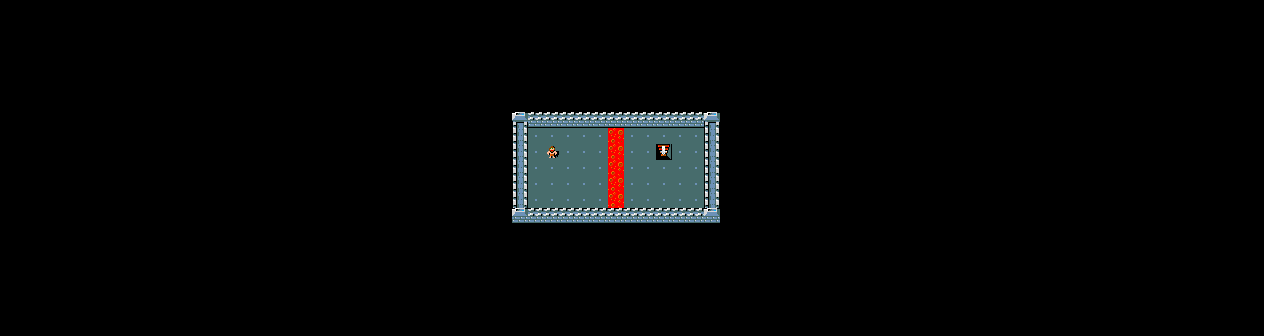

In [13]:
#env = gym.make("MiniHack-Room-5x5-v0", observation_keys=["glyphs","glyphs_crop","pixel","blstats","inv_glyphs","message"])
obs = env.reset()
display_screen(obs)
#obs["glyphs_crop"].shape

In [14]:
agent = Agent(alpha=0.0005, gamma =0.99, n_actions = env.action_space.n)
#agent = Agent(alpha=0.05, gamma =0.9, n_actions = env.action_space.n)

score_history = [] 
n_episodes = 1000

for i in range(n_episodes):
    done = False
    score = 0 
    observation = format_obs(env.reset())
    
    while not done:
        action = agent.choose_action(observation)
        #print(action)   
        observation_, reward, done, info = env.step(action)
        observation_ = format_obs(observation_)
        agent.store_transition(observation, action, reward)
        observation = observation_ 
        score += reward 
    score_history.append(score)
    
    agent.learn()
    
    avg_score = np.mean(score_history[-100:])
    print('episode ', i, 'score %.1f' % score, 'avg score %.1f' % avg_score)
    
plt.plot(score_history)

2021-11-01 20:06:25.739866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-01 20:06:25.740934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


/var/folders/wm/vfztc0rx29d3qrfj3k_2nkgm0000gn/T/ipykernel_70505/1743424471.py:11: RuntimeWarning: invalid value encountered in true_divide
  message = np.array(observation["message"]/observation["message"].max())
/var/folders/wm/vfztc0rx29d3qrfj3k_2nkgm0000gn/T/ipykernel_70505/1743424471.py:8: RuntimeWarning: invalid value encountered in true_divide
  stats = np.array(observation["blstats"]/observation["blstats"].max())


episode  0 score -1.0 avg score -1.0
episode  1 score -0.8 avg score -0.9
episode  2 score -0.2 avg score -0.7
episode  3 score -0.6 avg score -0.6
episode  4 score -0.6 avg score -0.6
episode  5 score -0.7 avg score -0.6
episode  6 score 0.1 avg score -0.5
episode  7 score -1.5 avg score -0.7
episode  8 score -0.2 avg score -0.6
episode  9 score 0.3 avg score -0.5
episode  10 score 0.5 avg score -0.4
episode  11 score -3.3 avg score -0.6
episode  12 score 0.0 avg score -0.6
episode  13 score -0.3 avg score -0.6
episode  14 score -0.1 avg score -0.5
episode  15 score -0.2 avg score -0.5
episode  16 score -0.2 avg score -0.5
episode  17 score -0.0 avg score -0.5
episode  18 score -0.1 avg score -0.5
episode  19 score -0.7 avg score -0.5
episode  20 score -0.1 avg score -0.5
episode  21 score -0.1 avg score -0.4
episode  22 score -0.1 avg score -0.4
episode  23 score -0.0 avg score -0.4
episode  24 score -0.1 avg score -0.4
episode  25 score -0.1 avg score -0.4
episode  26 score -0.3 avg

KeyboardInterrupt: 

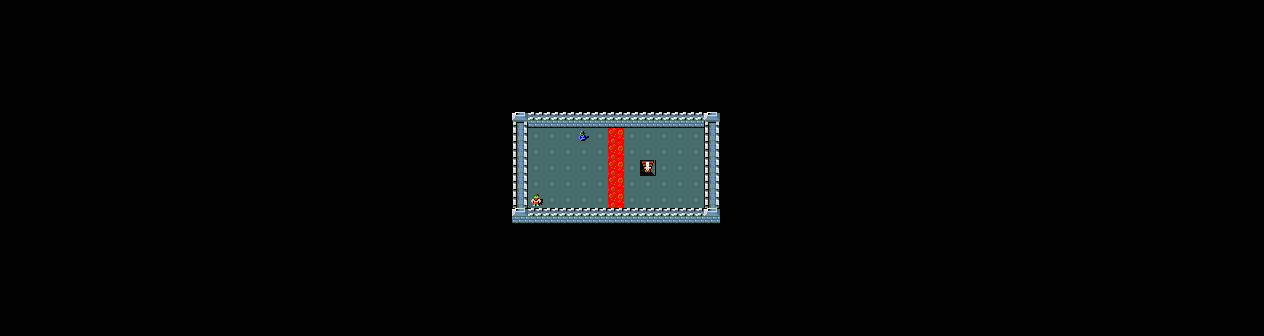

reward 1.0


In [31]:
observation = env.reset()
done = False 
while not done:
    display_screen(observation)
    action = agent.choose_action(format_obs(observation))
    observation_, reward, done, info = env.step(action)
    print('reward',reward)
    observation = observation_ 